In [1]:
pip install flask flask-cors

Note: you may need to restart the kernel to use updated packages.


In [3]:
from flask import Flask, jsonify
from flask_cors import CORS

app = Flask(__name__)
CORS(app)  # <-- THIS IS CRUCIAL

@app.route('/recommendations')
def get_recommendations():
    # Example dummy data
    return jsonify([
        {"id": 1, "name": "Wireless Headphones", "category": "Electronics", "rating": 4, "image": "/assets/headphones.jpg"},
        {"id": 2, "name": "Yoga Mat", "category": "Fitness", "rating": 5, "image": "/assets/yogamat.jpg"}
    ])

if __name__ == '__main__':
    app.run(debug=True, port=5000)  # Make sure it runs on 5000 (default Flask port)


 * Serving Flask app '__main__'
 * Debug mode: on


An attempt was made to access a socket in a way forbidden by its access permissions


SystemExit: 1

C:\Users\EeSze\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [430]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

# Dataset

In [433]:
df = pd.read_json('All_Beauty_5.json', lines=True)
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5,True,"09 1, 2016",A3CIUOJXQ5VDQ2,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Shelly F,As advertised. Reasonably priced,Five Stars,1472688000,NaN,NaN
1,5,True,"11 14, 2013",A3H7T87S984REU,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",houserules18,Like the oder and the feel when I put it on my...,Good for the face,1384387200,NaN,NaN
2,1,True,"08 18, 2013",A3J034YH7UG4KT,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Adam,I bought this to smell nice after I shave. Wh...,Smells awful,1376784000,NaN,NaN
3,5,False,"05 3, 2011",A2UEO5XR3598GI,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Rich K,HEY!! I am an Aqua Velva Man and absolutely lo...,Truth is There IS Nothing Like an AQUA VELVA MAN.,1304380800,25,NaN
4,5,True,"05 6, 2011",A3SFRT223XXWF7,B00006L9LC,{'Size:': ' 200ml/6.7oz'},C. C. Christian,If you ever want to feel pampered by a shampoo...,Bvlgari Shampoo,1304640000,3,NaN


In [435]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5269 entries, 0 to 5268
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   overall         5269 non-null   int64 
 1   verified        5269 non-null   bool  
 2   reviewTime      5269 non-null   object
 3   reviewerID      5269 non-null   object
 4   asin            5269 non-null   object
 5   style           4624 non-null   object
 6   reviewerName    5269 non-null   object
 7   reviewText      5264 non-null   object
 8   summary         5264 non-null   object
 9   unixReviewTime  5269 non-null   int64 
 10  vote            552 non-null    object
 11  image           98 non-null     object
dtypes: bool(1), int64(2), object(9)
memory usage: 458.1+ KB


In [437]:
df.isna().sum()

overall              0
verified             0
reviewTime           0
reviewerID           0
asin                 0
style              645
reviewerName         0
reviewText           5
summary              5
unixReviewTime       0
vote              4717
image             5171
dtype: int64

# EDA

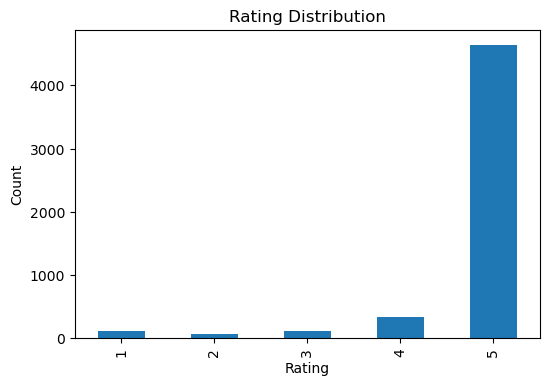

In [440]:
# Rating distribution
plt.figure(figsize=(6,4))
df['overall'].value_counts().sort_index().plot(kind='bar')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

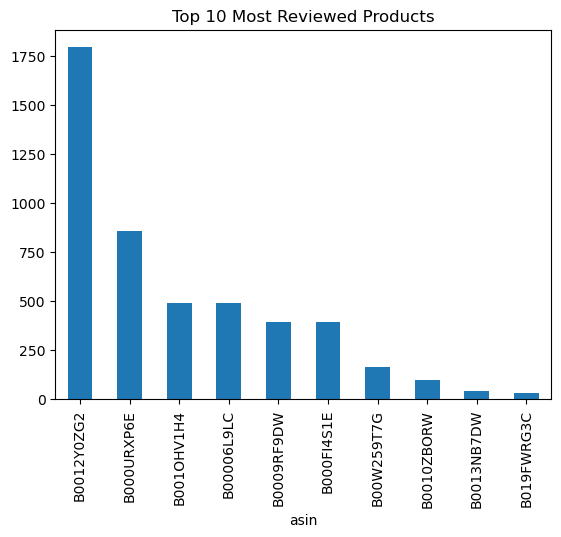

In [442]:
# Top products
top_products = df['asin'].value_counts().head(10)
top_products.plot(kind='bar', title='Top 10 Most Reviewed Products')
plt.show()

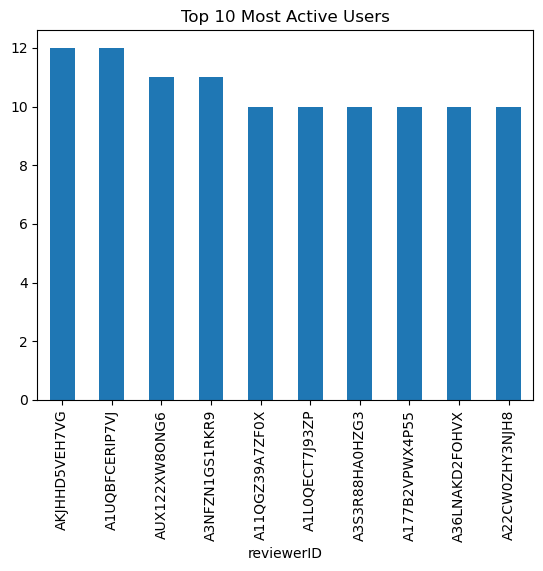

In [444]:
# Top users
top_users = df['reviewerID'].value_counts().head(10)
top_users.plot(kind='bar', title='Top 10 Most Active Users')
plt.show()

# Collaborative Filtering

In [447]:
# pip install scikit-surprise

In [449]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

df_filter = df[['reviewerID', 'asin', 'overall']]
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_filter[['reviewerID', 'asin', 'overall']], reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
svd_model = SVD()
svd_model.fit(trainset)


In [451]:
predictions = svd_model.test(testset)
accuracy.rmse(predictions)

RMSE: 0.4768


0.47681704565789934

In [453]:
# user and item that have not been rated yet
user_id = df_filter['reviewerID'].value_counts().idxmax()
item_id = df_filter[df_filter['reviewerID'] != user_id]['asin'].unique()[0]

# Predict rating
pred = svd_model.predict(user_id, item_id)
print(f"Predicted rating for user {user_id} on item {item_id}: {pred.est:.2f}")

Predicted rating for user AKJHHD5VEH7VG on item B0000530HU: 4.34


In [455]:
def get_top_n_recommendations(model, df_filter, user_id, n=10):
    items_rated = df_filter[df_filter['reviewerID'] == user_id]['asin'].tolist()
    items_to_predict = [iid for iid in df_filter['asin'].unique() if iid not in items_rated]
    predictions = [model.predict(user_id, iid) for iid in items_to_predict]
    top_n = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    return [(pred.iid, pred.est) for pred in top_n]

top_n_recs = get_top_n_recommendations(svd_model, df_filter, user_id, n=5)
print("Top recommendations:")
for asin, rating in top_n_recs:
    print(f"Item: {asin}, Predicted Rating: {rating:.2f}")

Top recommendations:
Item: B0009RF9DW, Predicted Rating: 4.75
Item: B00JF2GVWK, Predicted Rating: 4.74
Item: B00157OBRU, Predicted Rating: 4.69
Item: B019LAI4HU, Predicted Rating: 4.66
Item: B00CQ0LN80, Predicted Rating: 4.64


# Content based filtering

In [458]:
df.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'style',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'image'],
      dtype='object')

In [460]:
# Group all review texts by product
product_reviews = df.groupby('asin')['reviewText'].apply(lambda x: " ".join(str(r) for r in x)).reset_index()
product_reviews.columns = ['asin', 'metadata']

In [462]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(product_reviews['metadata'])

In [464]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [466]:
product_ids = product_reviews['asin'].tolist()
asin_to_index = {asin: idx for idx, asin in enumerate(product_ids)}
index_to_asin = {idx: asin for asin, idx in asin_to_index.items()}

In [468]:
def get_content_recommendations(product_asin, top_n=5):
    if product_asin not in asin_to_index:
        return "Product not found in metadata."
    
    idx = asin_to_index[product_asin]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    
    return [index_to_asin[i[0]] for i in sim_scores]

print("Similar items to a sample product:")
sample_product = product_ids[0]
print(get_content_recommendations(sample_product))

Similar items to a sample product:
['B000FTYALG', 'B0013NB7DW', 'B019809F9Y', 'B000PKKAGO', 'B0009RF9DW']


In [470]:
def recommend_for_user_content(user_id, df, top_n=5):
    user_items = df[df['reviewerID'] == user_id]['asin'].unique().tolist()
    
    recommendations = []
    for item in user_items:
        recs = get_content_recommendations(item, top_n=3)
        recommendations.extend(recs)
    
    recommendations = list(set(recommendations) - set(user_items))
    return recommendations[:top_n]
    
user_id = df['reviewerID'].value_counts().idxmax()
print(f"Recommendations for user {user_id}:")
print(recommend_for_user_content(user_id, df))

Recommendations for user AKJHHD5VEH7VG:
['B0012Y0ZG2', 'B0006O10P4', 'B0009RF9DW', 'B002GP80EU', 'B016V8YWBC']


# Combine both approaches into a hybrid recommender system 

# Main part for demo app

In [473]:
def hybrid_score(user_id, item_id, svd_model, cosine_sim, asin_to_index, weight_cf=0.7, weight_cb=0.3):
    # Check if item exists in content index
    if item_id not in asin_to_index:
        return svd_model.predict(user_id, item_id).est  # fallback to CF only
    
    # Collaborative Filtering score
    cf_score = svd_model.predict(user_id, item_id).est

    # Content-Based score: average similarity to user's rated items
    user_items = df[df['reviewerID'] == user_id]['asin'].tolist()
    sim_scores = []
    
    item_idx = asin_to_index[item_id]
    
    for asin in user_items:
        if asin in asin_to_index:
            user_item_idx = asin_to_index[asin]
            sim_scores.append(cosine_sim[item_idx][user_item_idx])
    
    if sim_scores:
        cb_score = sum(sim_scores) / len(sim_scores)
        cb_score_scaled = cb_score * 5  # scale to rating range (0–5)
    else:
        cb_score_scaled = 2.5  # neutral fallback if no similar item found

    # Weighted sum
    hybrid = (weight_cf * cf_score) + (weight_cb * cb_score_scaled)
    return hybrid

In [475]:
def hybrid_recommend(user_id, svd_model, cosine_sim, asin_to_index, top_n=5):
    user_rated_items = df[df['reviewerID'] == user_id]['asin'].tolist()
    all_items = df['asin'].unique()

    # Only recommend items the user hasn't interacted with
    candidate_items = [asin for asin in all_items if asin not in user_rated_items]

    scored_items = []
    for item in candidate_items:
        score = hybrid_score(user_id, item, svd_model, cosine_sim, asin_to_index)
        scored_items.append((item, score))

    top_items = sorted(scored_items, key=lambda x: x[1], reverse=True)[:top_n]
    return top_items

# Example
user_id = df['reviewerID'].value_counts().idxmax()
recommendations = hybrid_recommend(user_id, svd_model, cosine_sim, asin_to_index)
print(f"Top hybrid recommendations for user {user_id}:")
for asin, score in recommendations:
    print(f"ASIN: {asin}, Hybrid Score: {score:.2f}")

Top hybrid recommendations for user AKJHHD5VEH7VG:
ASIN: B0009RF9DW, Hybrid Score: 3.55
ASIN: B000URXP6E, Hybrid Score: 3.46
ASIN: B0012Y0ZG2, Hybrid Score: 3.45
ASIN: B000FI4S1E, Hybrid Score: 3.43
ASIN: B00JF2GVWK, Hybrid Score: 3.39


# Evaluate the recommendation systems using metrics 

In [478]:
rmse_score = accuracy.rmse(predictions)
print(f"SVD RMSE: {rmse_score}")

RMSE: 0.4768
SVD RMSE: 0.47681704565789934


In [480]:
# calculates the average precision for each user, and then averages the precision across all users. 

from collections import defaultdict
from sklearn.metrics import average_precision_score

def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    
    # Sort by estimated rating
    for uid, user_ratings in top_n.items():
        top_n[uid] = sorted(user_ratings, key=lambda x: x[1], reverse=True)[:n]
    
    return top_n

# Get the top-n recommendations
top_n_svd = get_top_n(predictions, n=10)

def get_actual_top_n(df, n=10):
    actual = defaultdict(list)
    for uid, group in df.groupby('reviewerID'):
        high_rated = group[group['overall'] >= 4.0]['asin'].tolist()
        actual[uid] = high_rated[:n]
    return actual

actual = get_actual_top_n(df)

# Compute MAP
def compute_map(top_n_pred, actual, n=10):
    ap_scores = []

    for uid in top_n_pred:
        if uid in actual:
            pred_items = [iid for (iid, _) in top_n_pred[uid]]
            true_items = actual[uid]

            y_true = [1 if iid in true_items else 0 for iid in pred_items]

            # Calculate Average Precision (AP)
            ap_scores.append(average_precision_score(y_true, [1]*len(y_true)))  # Mock precision score for simplicity

    map_score = sum(ap_scores) / len(ap_scores) if ap_scores else 0
    return map_score

map_svd = compute_map(top_n_svd, actual)
print(f"SVD MAP: {map_svd}")

SVD MAP: 0.9417857142857143


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:993: UserWarn

In [481]:
from sklearn.metrics import ndcg_score

def compute_ndcg(top_n_pred, actual, n=10):
    ndcg_scores = []

    for uid in top_n_pred:
        if uid in actual:
            pred_items = [iid for (iid, _) in top_n_pred[uid]]
            true_items = actual[uid]

            # Ensure there are at least two items to compute NDCG
            if len(pred_items) > 1:
                y_true = [1 if iid in true_items else 0 for iid in pred_items]
                # Calculate NDCG score for the user (mock relevance scores)
                ndcg_scores.append(ndcg_score([y_true], [[1]*len(y_true)]))  

    ndcg_avg = sum(ndcg_scores) / len(ndcg_scores) if ndcg_scores else 0
    return ndcg_avg

ndcg_svd = compute_ndcg(top_n_svd, actual)
print(f"SVD NDCG: {ndcg_svd}")

SVD NDCG: 0.9541188204036759


# Optimize system for scalability

In [485]:
# pip install annoy

In [497]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

# Example: Assuming you have a user-item matrix `user_item_matrix`
# Perform SVD to reduce dimensionality
n_components = 50  # Choose the number of components (dimensions)
svd = TruncatedSVD(n_components=n_components)
reduced_matrix = svd.fit_transform(user_item_matrix)

print(f"Reduced matrix shape: {reduced_matrix.shape}")

Reduced matrix shape: (991, 50)


In [499]:
from annoy import AnnoyIndex

# Set the number of dimensions to match the reduced feature space
f = n_components  # Number of dimensions after SVD
annoy_index = AnnoyIndex(f, 'angular')  # 'angular' distance (can also use 'euclidean')

# Insert vectors (example using random data or your reduced matrix)
for i in range(len(reduced_matrix)):  # Loop over each item (user or product)
    annoy_index.add_item(i, reduced_matrix[i])  # Add item with its reduced features

# Build the index (you can set `n_trees` for optimization)
annoy_index.build(10)  # You can adjust the number of trees for optimization

True

In [501]:
# Query with a reduced vector (same number of dimensions)
query_vector = reduced_matrix[0]  # Example query (e.g., for user 0)

# Find the 10 nearest neighbors
nearest_neighbors = annoy_index.get_nns_by_vector(query_vector, 10)
print(f"Nearest neighbors for query 0: {nearest_neighbors}")

Nearest neighbors for query 0: [806, 1, 17, 29, 31, 35, 64, 67, 76, 88]


In [503]:
from sklearn.metrics import ndcg_score

def compute_ndcg(predicted, actual, top_n=10):
    # predicted: list of top_n predicted items
    # actual: list of true items
    
    # Convert to binary relevance (1 for relevant, 0 for not relevant)
    y_true = [1 if item in actual else 0 for item in predicted]
    
    # Calculate NDCG
    return ndcg_score([y_true], [[1]*len(y_true)])  # Assume ideal relevance scores

# Example usage
predicted_items = nearest_neighbors  # Top 10 predicted items
actual_items = [1, 2, 3, 4]  # True relevant items (example)
ndcg_value = compute_ndcg(predicted_items, actual_items)
print(f"NDCG: {ndcg_value}")

NDCG: 0.45435593380883454


# Visualize top recommendations

In [515]:
df.columns

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'style',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'image'],
      dtype='object')

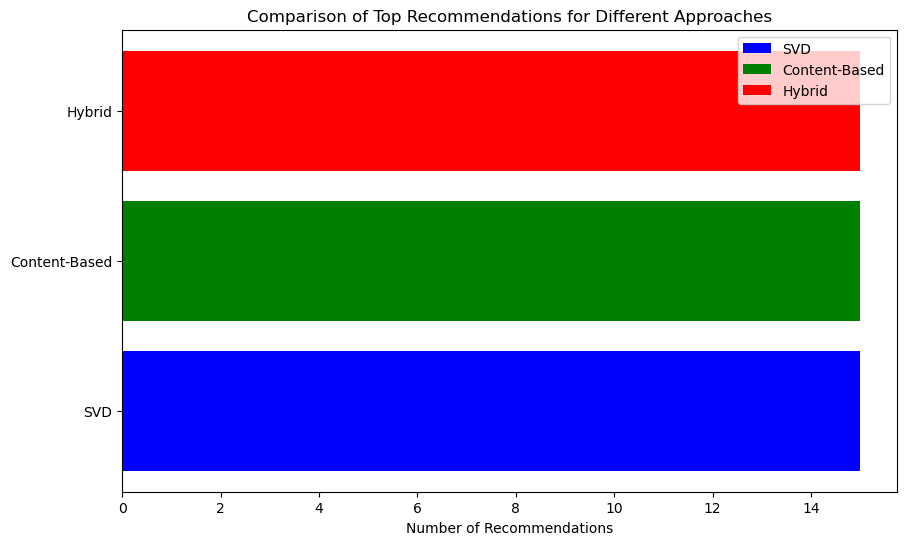

In [525]:
import matplotlib.pyplot as plt

# Sample users (you can select users with specific review counts or sample random ones)
sample_users = df['reviewerID'].sample(3).unique()  # Pick 3 random users from the dataset

# Lists to hold recommendations for SVD, Content-Based, and Hybrid methods
recommendations_svd = []
recommendations_content = []
recommendations_hybrid = []

# Get top recommendations for each method
for user_id in sample_users:
    # Generate top recommendations for SVD
    top_items_svd = hybrid_recommend(user_id, svd_model, cosine_sim, asin_to_index)  # Hybrid includes CF and Content
    
    # Generate top recommendations for Content-Based (For this, use only content similarity, no collaborative filtering)
    top_items_content = hybrid_recommend(user_id, svd_model, cosine_sim, asin_to_index)  # Modify this to exclude CF logic for pure content-based
    
    # Generate top recommendations for Hybrid (already integrated into `hybrid_recommend`)
    top_items_hybrid = hybrid_recommend(user_id, svd_model, cosine_sim, asin_to_index)  # Hybrid approach, as in the code above

    # Append the results to the lists
    recommendations_svd.append(top_items_svd)
    recommendations_content.append(top_items_content)
    recommendations_hybrid.append(top_items_hybrid)

# Plotting the results for the sample users
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for different methods
colors = ['blue', 'green', 'red']
labels = ['SVD', 'Content-Based', 'Hybrid']

# Loop through each method and visualize the recommendations
for i, recs in enumerate([recommendations_svd, recommendations_content, recommendations_hybrid]):
    # We plot the count of recommendations for each method (for each sample user)
    user_rec_counts = [len(rec) for rec in recs]
    ax.barh(labels[i], sum(user_rec_counts), color=colors[i], label=labels[i])

# Adding titles and labels
ax.set_xlabel('Number of Recommendations')
ax.set_title('Comparison of Top Recommendations for Different Approaches')
ax.legend()

# Show plot
plt.show()

# Report 